## A (very) brief introduction to Color Doppler 

Color doppler is a medical imaging modality for blood flow imaging.  
It bases on the Doppler effect.  
Doppler effect is a shift of a received signal frequency, when the wave source is moving relatively to the receiver.  
In medicine 'sources' (i.e. moving tissue, specifically blood) do not emits acoustic waves, but are 'iluminated' by a ultrasound pulses produced by a probe.  
It can be shown [Evans2000] that the shift in the received frequency is given by following equation:

$
f_d = f_t - f_r = \frac{2f_tv\cos{\alpha}}{c}
$

where
* $f_d$ - frequency shift, or doppler frequency,
* $f_t$ - transmitted frequency, 
* $f_r$ - received frequency, 
* $v$ - speed of the blood,
* $\alpha$ - the angle between the ultrasound beam and the direction of motion of the blood,
* $c$ - speed of sound in the medium. It is usually assumed that in soft tissue $c = 1540 [m/s]$.



<!-- When the medical probe transmits the ultrasound pulse, and it is scattered on moving blood (i.e. on blood cells), the received echoes changes in phase.    -->
In classical approach the probe transmits a series of (quite long) ultrasound pulses, receiving echoes after each transmit.  
The series consists of $N$ transmit/receive (TR) events, and the higher $N$, the higher sensitivity, but lower doppler framerate.  
Typically $N$ could be in the range of $8-16$ for classical methods and $32-256$ for synthetic aperture methods, however there are no strict rules.  
The TR events in the series are repeated with constant Pulse Repetition Frequency (PRF).  
Thus the time between TR events - Pulse Repetition Interval (PRI) is equal $\frac{1}{PRF}$.  
The received signals are IQ demodulated. Then, the high-pass filter in 'slow time' (the so-called wall clutter filter) is used.  
This filter is used for removing the constant echoes from non-flowing medium.  
The $f_d$ can be estimated from high-pass filtered IQ signal by means of autocorrelation esitmator:  

$
\overline{f_d} = \frac{1}{2\pi{}PRI} 
    \tan^{-1}{\left\{ 
        \frac{\sum^{N}_{i=1}{Q(i)I(i-1) - I(i)Q(i-1)}}
             {\sum^{N}_{i=1}{I(i)I(i-1) + Q(i)Q(i-1)}}
    \right\}}
$



<!-- , and next the phase is estimated for each sample.  
Then, for each sample the phase changes $\Delta{\theta}$ from TR to TR are calculated. Sometimes it is refered as phase changes in 'slow time'.  
The doppler frequency (averaged over time) can be calculated from the formula

$
\overline{f_d} = \frac{1}{N-1} \sum_{n=1}^{N-1} \frac{\Delta{\theta}_{n}}{PRI}
$

 -->
Then, we can use the following formula to estimate (average) speed of the blood flow.  

$
v_s = \frac{\overline{f_d}}{f_t} \frac{c}{2\cos{\alpha}}
$





The second mode used in medical flow imaging is power doppler, i.e. the power of the doppler signal.  
The power $p$ can be estimated using following estimator:

$
p = \sum^{N}_{i=1}{I(i)I(i) + Q(i)Q(i)}
$

The $p$ will be used to create a mask when displaying the flow - only those areas with adequate doppler signal strength will be displayed.


--------------------------------------------------------------------------------

In [1]:
import cupy as cp
import numpy as np
import scipy.signal as spsig
import matplotlib.pyplot as plt
from gpu_short_course.ultrasound_imaging import (
    to_bmode,
    show_flow,
    filter_wall_clutter_gpu,
    iq2bmode_gpu,
    display_bmode
)

#### Kernel definition
The following kernel estimate both (non-scaled) doppler frequency and the power.  
Since similar data is used to estimate both, this is more optimal than creating two separate kernels.  

In [2]:
source = r"""

#include <cupy/complex.cuh>
extern "C" __global__ 
void dopplerColor(float *color, 
                  float *power, 
                  const complex<float> *iqFrames, 
                  const int nFrames, 
                  const int nx, 
                  const int nz)
                  
{
    int z = blockIdx.x * blockDim.x + threadIdx.x;
    int x = blockIdx.y * blockDim.y + threadIdx.y;

    
    if (z >= nz || x >= nx) {
        return;
    }
    
    /* Color estimation */
        
    complex<float> iqCurrent, iqPrevious;
    float ic, qc, ip, qp, pwr, nom = 0.0f, den = 0.0f;
    
    iqCurrent = iqFrames[z + x*nz];
    pwr = real(iqCurrent)*real(iqCurrent) +  
          imag(iqCurrent)*imag(iqCurrent);
    
    for (int iFrame = 1; iFrame < nFrames; iFrame++) {
    
        iqPrevious = iqCurrent;
        iqCurrent = iqFrames[z + x*nz + iFrame*nz*nx];
        
        ic = real(iqCurrent);
        qc = imag(iqCurrent);
        ip = real(iqPrevious);
        qp = imag(iqPrevious);
        
        pwr += ic*ic + qc*qc;
        den += ic*ip + qc*qp;
        nom += qc*ip - ic*qp;
    }
    color[z + x*nz] = atan2f(nom, den);
    power[z + x*nz] = pwr/nFrames;
    
    //color[z + x*nz] = abs(iqFrames[z + x*nz]); 
    //color[z + x*nz] = iqFrames[z + x*nz]; 
}

"""
cdoppler = cp.RawKernel(source, 'dopplerColor')


## Data processing for Color Doppler

#### Data loading

These 512 frames of IQ data were acquired from carotid artery of healthy volunteer.  
The single plane wave imaging (PWI) scheme was used.  
Transmit angle was about 20 degree, and receive angle was equal 0 degree.


The image below show the vessel as a darker region between 3-5 mm depth.   
The white triangle in the upper-left corner, and the rectangle at 0-1 mm depth are artifacts - ignore them. 
<!-- ![title](data/bmode.jpg) -->

<img src="data/bmode.jpg" width="400">

In [3]:
data = np.load('data/example_doppler_data.npz')
# data = np.load('data/npz/iqImgPK_batch01.npz')
iq = data['iq'] # frames of IQ data
xgrid = data['xgrid'] # vector of 'x' coordinates
zgrid = data['zgrid'] # vector of 'z' coordinates
prf = data['prf'] # pulse repetition frequency
c = data['c'] # speed of sound
tx_frequency = data['tx_frequency'] # transmit frequency


#### Color doppler estimation using defined kernel

In [4]:
# select frames for doppler processing (at least two)
first = 0
last = 512
frames = np.arange(first, last).astype(int)


In [5]:
# push iq data into gpu
iq_gpu = cp.array(iq)

# apply wall clutter filter
%time iq_wcfilt = filter_wall_clutter_gpu(iq_gpu, Wn=0.19, N=128)


CPU times: user 460 ms, sys: 5.42 ms, total: 466 ms
Wall time: 466 ms


In [6]:
# allocate memory on gpu for output data
nframes, nx, nz = iq_wcfilt.shape
color =  cp.zeros((nx, nz)).astype(cp.float32)
power =  cp.zeros((nx, nz)).astype(cp.float32)

# specify block and grid sizes
bx = 16
bz = 16
gx = np.ceil(nx/bx).astype(int)
gz = np.ceil(nz/bx).astype(int)
block = (bz, bx)
grid = (gz, gx)

# use kernel (and measure working time)
%time cdoppler(grid, block, (color, power, iq_wcfilt, nframes, nx, nz))

# get data from gpu
color = color.get().T
power = power.get().T


CPU times: user 288 µs, sys: 362 µs, total: 650 µs
Wall time: 615 µs


#### color scaling

In [7]:
# The transmit angle was ~20deg, receive angle was 0deg - lets assume 10deg effective angle
alpha = 10/180*np.pi

# doppler frequency
fd = prf/2/np.pi*color # [Hz]

# blood speed
v = fd/tx_frequency*c/2/np.cos(alpha)


#### Presentation of results 

In [8]:
# make b-mode array from non-filtered iq data and get it from gpu
center_frame = np.round(nframes/2).astype(int)
bmode = iq2bmode_gpu(iq_gpu[center_frame,:,:]).get().T


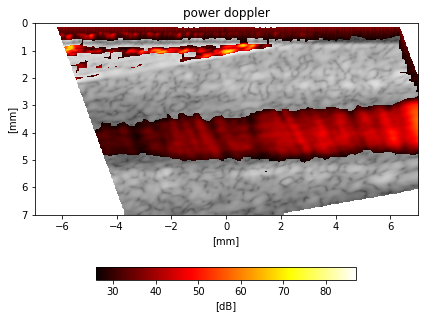

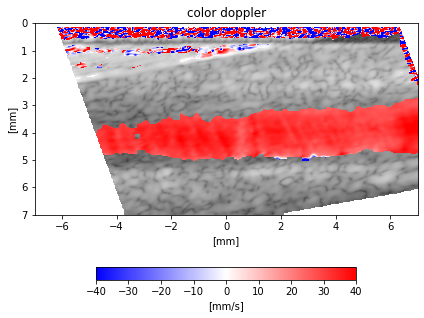

In [9]:
pthr = 27;

# power doppler
show_flow(bmode, color, power, xgrid, zgrid)

# raw color doppler
# show_flow(bmode, color, power, xgrid, zgrid, 'color', power_threshold=pthr)

# doppler frequency
# show_flow(bmode, fd, power, xgrid, zgrid, doppler_type='doppler frequency', power_threshold=pthr)


# blood speed
show_flow(bmode, v, power, xgrid, zgrid, 'speed', power_threshold=pthr)


-----------------------------------------

### References

[Evans2000] Evans, David H., and W. Norman McDicken. Doppler ultrasound: physics, instrumentation and signal processing. Wiley-Blackwell, 2000.